# A Tour of Models on Binary Data
- toc: true
- categories: [Julia, Turing]

To get myself comfortable with Julia and `Turing.jl`, I wrote out a bunch of toy models on the simplest of datasets: a simple vector of binary outcomes. To keep myself honest and to have something to refer to, I'm reproducing them here.

In [1]:
#collapse
using Turing
using Bijectors
using Gadfly
using DataFrames, DataFramesMeta
Gadfly.set_default_plot_size(25cm, 8cm)

## Standard Biased Coin Estimation
Coinflipping is a time-honored introductory example for probability, and for good reason. Readily interpretable, amenable to both analytical solutions and manual calculation. Nevermind that ["unfair" coins are essentially impossible to make](https://www.stat.berkeley.edu/~nolan/Papers/dice.pdf)...

We'll build two models that are essentially the same but have distinct computational profiles. Bernoulli:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1)\\
y_i &\sim \mathrm{Bernoulli}(\beta)\\
\end{aligned}$$

And Binomial:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1)\\
\mathrm{sum}(y) &\sim \mathrm{Binomial}(\mathrm{length}(y), \beta)\\
\end{aligned}$$

### Bernoulli Model

In [2]:
@model function coinflip(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    for i in 1:length(y)
        y[i] ~ Bernoulli(p)
    end
end;

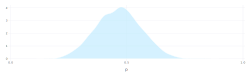

In [3]:
data = [1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0]

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 2000
ϵ = 0.05
τ = 10;

chain_bernoulli = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false);

plot(DataFrame(chain_bernoulli), x=:p, Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true),
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0)
)

### Binomial Model
Now let's take a look at an equivalent model that expresses the exact same underlying phenomena. In Turing:

In [4]:
@model function coinflip_binomial(heads::Int64, flips::Int64)
    # prior on p
    p ~ Beta(1, 1)
    
    # update on p
    heads ~ Binomial(flips, p)
end;

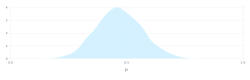

In [5]:
#collapse
heads = sum(data)
flips = length(data)

chain_binomial = sample(
    coinflip_binomial(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false);

plot(DataFrame(chain_binomial), x=:p, Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true),
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0)
)

### Other Parametriziations
Going further afield, we can also model $\beta$ on an unconstrained scale ($\mathbb{R}$ instead of the unit interval $[0,1]$) by linking the domains with $\mathrm{logit}^{-1}(x) = \frac{e^x}{e^x + 1}$. 

$$\begin{aligned}
\rho &\sim \mathrm{Beta}(1,1)\\
\beta &= \mathrm{logit}^{-1}(\rho)\\
y_i &\sim \mathrm{Bernoulli}(\beta)
\end{aligned}$$

On it's own, this seems like a frivolous transformation but it allows us to incorporate multiple signals into our determination of the probability of a positive result. This is logistic regression. Imagine we have one outcome $y$ that depends on several inputs $x_1, x_2, \ldots, x_n$:

$$\begin{aligned}
\rho_i &\sim \mathrm{Normal}(0,1)\\
\beta &= \mathrm{logit}^{-1}(\rho_1 x_1 + \rho_2 x_2 + \ldots + \rho_n x_n)\\
y_i &\sim \mathrm{Bernoulli}(\beta)
\end{aligned}$$

The same logic applies to Binomial:

$$\begin{aligned}
\rho_i &\sim \mathrm{Normal}(0,1)\\
\beta &= \mathrm{logit}^{-1}(\rho_1 x_1 + \rho_2 x_2 + \ldots + \rho_n x_n)\\
\mathrm{sum}(y) &\sim \mathrm{Binomial}(\mathrm{length}(y), \beta)
\end{aligned}$$

If we didn't apply this transformation then adding up the components of $\beta$ could lead to values outside of $[0,1]$, ie not in the support of the Bernoulli distribution.

Turing allows us to create a `logit` function in two ways. One is in pure Julia code (type assertions can get messy here with automatic differentiation):

In [6]:
function invlogit(x)
    ex = exp(x)
    return ex / (1 + ex)
end;

It's also possible to use some transformations that Turing uses internally from the `Bijectors.jl` library. Some sampling algorithms like HMC require an unbounded sampling space to (or something like it subject to `Float64` constraints...). In order to enable that, the `Bijectors` library creates functions that map (smoothly) between continuous spaces. In 

In [18]:
logit = bijector(Beta())   # bijection:  (0, 1)  →  ℝ
inv_logit = inv(logit)     # bijection:       ℝ  →  (0, 1)

@model function coinflip_invlogit(heads::Int64, flips::Int64)
    # prior on p
    logit_p ~ Normal(0, 1) # or any unbounded distribution
    
    # update on p
    heads ~ Binomial(flips, invlogit(logit_p))
end;

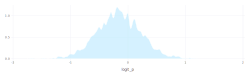

In [34]:
#collapse
heads = sum(data)
flips = length(data)

chain_invlogit = sample(
    coinflip_invlogit(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false);

plot(DataFrame(chain_invlogit), x=:logit_p, Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true),
    Coord.cartesian(ymin=0.0)
)

Note the new x-axis which is the transformation of the previous axis. Here are some helpful values: 

$$
\begin{aligned}\mathrm{logit}^{-1}(1.0) &= 0.73\\
\mathrm{logit}^{-1}(0) &= \frac{1}{2}\\
\mathrm{logit}^{-1}(-1.0) &= 0.27
\end{aligned}$$

### Performance Difference
Note that the inference here should be faster than the Bernoulli case especially as the volume of data increases. The log-likelihood calculations in each sample loop are $O(1)$ versus $O(\mathrm{rows})$ in the Bernoulli variant. Let's take a look with a modestly larger dataset.

In [35]:
long_data = repeat(data, 10);
@time sample(
    coinflip(long_data), 
    HMC(ϵ, τ), iterations, 
    progress=false);

  7.658380 seconds (64.01 M allocations: 1.933 GiB, 6.88% gc time)


In [36]:
heads = sum(long_data)
flips = length(long_data)
@time sample(
    coinflip_binomial(heads, flips), 
    HMC(ϵ, τ), iterations, 
    progress=false);

  0.105582 seconds (659.91 k allocations: 46.448 MiB, 24.33% gc time)


### Caution!
Note that the following won't work, due to design choices in Turing:

In [37]:
@model function coinflip_BROKEN_THIS_WONT_WORK_AAAAAGH(y::Array{Int64})
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p                    # these lines are the problem.
    heads = sum(y)                    # heads is not RV or argument
    heads ~ Binomial(length(y), p)    # so it can't be on LHS of ~
end;

The reason is that Turing assumes that all variables on the left hand side of `~` are either 
1. random variables (generated by Turing) or
2. declared as inputs to the function

By way of analogy to Stan, the `@model` block is only intended to represent the `parameter`, `tranformed parameter` and `model` blocks. As Turing is just Julia code, this is little inconvenience (just do the data transformations in Julia first, it's more efficient anyway!) but it can be a bit of a surprise and the error message is difficult to interpret.

## Incorporating Prior Knowledge

The above are interesting in that both depend on unexplained constants in the Beta distribution ($\mathrm{Beta}(1,1)$ vs, say, $\mathrm{Beta}(13.859, \pi)$). Those values are left unjustified and here we'll put some more thought into them.

Let's assume you are passingly familiar with the concept of flipping coins. Consequently you reasonably expect nearly every coin to be fair and nearly every person you know to not be [Persi Diaconis](https://news.stanford.edu/pr/2004/diaconis-69.html). Personally, I'd need to see a lot of data to accept that a coin had a substantial bias, so in this section we explore to bake that prior knowledge into our model as our prior distribution (the parameters of Beta, in this case). This is a small change to the model but we'll explore the impacts of a few alternatives for constraints on $\beta$:

$$\begin{aligned}
\beta &\sim \mathrm{Beta}(1,1) &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(5,5)  &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(50,50)  &\mathrm{\ versus}\\
\beta &\sim \mathrm{Beta}(15,5)&\mathrm{\ (for\ fun)}\\
\end{aligned}$$

plot distributions
http://gadflyjl.org/stable/gallery/statistics/#

With 3 priors (Beta(1,1), Beta(4.9, 5.1), Beta(49, 51)):
1. Plot comparison of prior distributions
1. Plot comparison of posterior distributions

## Sequential Dependencies

The preceeding examples are about as far as coin flipping can take us, so let's begin exploring data that has more interesting structure. The first challenge we'll tackle is dependence between subsequent data elements. This is cheating a little bit, since we're no longer strictly dealing with binary data as we are also incorporating the order of the elements. In my opinion, this lives in the realm of prior knowledge: we believe a priori that the sort order of the data we received is equal to the temporal order of the data as it was generated. 

Here is a very simple model to capture this dependency:

$$\begin{aligned}
\beta_0 &\sim \mathrm{Beta}(1,1)\\
\beta_1 &\sim \mathrm{Beta}(1,1)\\
y_i &\sim \begin{cases} \mathrm{Bernoulli}(\beta_0) & y_{i-1} = 0 \\ \mathrm{Bernoulli}(\beta_1) & y_{i-1} = 1 \end{cases}
\end{aligned}$$

Note that if we incorrectly accepted an assumption of independence as in our previous models then our point estimate of `p` will not converge as quickly as expected, and our confidence intervals will be much too narrow. In other words, if we have positive autocorrelation (flipping a 1 is more likely if the preceeding flip was also a 1, and the reverse) then our estimates will just be wrong unless we account for it explicitly.

Let's generate some data in a way that very explicitly shows the connection to the previous datapoint:

In [44]:
data_autocor = [1]
p_1 = 0.85
p_2 = 0.35
for i in 2:1000
    if data_autocor[i-1] == 1
        p = p_1
    else
        p = p_2
    end
    data_autocor = cat(data_autocor, rand(Bernoulli(p)), dims=1)
end

And here's a model - it's not an accident that the model code looks so close to the data generating code!

In [45]:
@model function coinflip_autocor(y::Array{Int64})
    # prior on p
    p_1 ~ Beta(1, 1)
    p_2 ~ Beta(1, 1)
    
    y[1] ~ Bernoulli(p_1)       # I arbitrarily chose p_1
    for i in 2:length(y)
        if y[i-1] == 1
            p = p_1
        else
            p = p_2
        end
        y[i] ~ Bernoulli(p)
    end
end;

Here are the estimates of the two parameters:

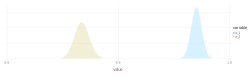

In [46]:
#collapse
chain_autocor = sample(coinflip_autocor(data_autocor), HMC(ϵ, τ), iterations, progress=false)[500:end];
ch_autocor_df = @linq DataFrame(chain_autocor) |> 
    select(:p_1, :p_2) |> 
    DataFrames.stack();
plot(DataFrame(ch_autocor_df), x=:value, color=:variable, Theme(alphas=[0.6]),
    Stat.density(bandwidth=0.02), Geom.polygon(fill=true, preserve_order=true),
    Coord.cartesian(xmin=0.0, xmax=1.0, ymin=0.0), Guide.yticks(label = false)
)

We have less certainty about $p_2$ than $p_1$. This is predictable from the data generation process: because heads are more likely to beget heads than tails are to beget tails (ie $p_1$ is closer to 1 than $p_2$ is to 0), we have more examples drawing from the $p_1$ distribution.

How to do this with an honest covariance matrix? ie over zip(y[:-1], y[2:])?
What about a "rich get richer" scenario? P(1) ~ b + length of streak of 1s
- would look good but how to diagnose issues?
    - distributions of streaks! a lot of extremely long streaks, a lot of short streaks... 

what about a "machine error" - double readings for both or one of 1s / 0s?

## Wide Dependencies: Rich get Richer
Look, we're long passed the physical analogy making sense for this data so just roll with it for now. The idea for this scenario is a minor extension of the former: every consecutive flip heads makes it more likely the next flip will also be heads, and the reverse for tails.

In [41]:
function streaks(arr)
    streaks = []
    val = arr[1]
    current_streak = 1
    for i in 2:length(arr)
        next_val = arr[i]
        if next_val == val
            current_streak = current_streak + 1
        else
            streaks = cat(streaks, current_streak, dims=1)
            val = next_val
            current_streak = 1
        end
    end
    streaks = cat(streaks, current_streak, dims=1)
    return streaks
end;

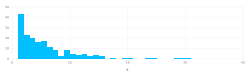

In [43]:
plot(DataFrame(x=streaks(data_autocor)), x=:x, Geom.histogram)

## Many Streams with Discrete Biases

"data on several coins from specific mints. Coin of unknown origin with 10 flips, what is P(heads) on next flip?"

## Many Streams with Continuous Biases

All coins come from one rather shitty mint. How shitty is that mint, and how shitty is this coin?

$$\begin{aligned}
\mu_{mint} &\sim \mathrm{Normal}(0,1) \\
\sigma_{mint} &\sim \mathrm{Normal}(1, 2) \\
\mu_{coin} &\sim \mathrm{Normal}(\mu_{mint}, \sigma_{mint}) \\
ys &\sim \mathrm{Bernoulli}(\mu_{coin}) \\ 
\end{aligned}$$

Compare naive estimate and regularized estimate. Note: regularization lets us "share error" between

## "Seasonal" data
e.g. hourly aggregate from a motion sensor in a shop: "there was motion in the shop over the past hour"

## Extremely sparse data?